In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
import os.path
import csv
from tensorflow.python.framework import ops

ops.reset_default_graph()

In [4]:
# Obtain and prepare data for modeling

# name of data file# name  
birth_weight_file = 'birth_weight.csv'

# download data and create data file if file does not exist in current directory
if not os.path.exists(birth_weight_file):
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
    with open(birth_weight_file, "w") as f:
        writer = csv.writer(f)
        writer.writerows(birth_data)
        f.close()

# read birth weight data into memory
birth_data = []
with open(birth_weight_file, 'r') as csvfile:
     csv_reader = csv.reader(csvfile)
     birth_header = next(csv_reader)
     for row in csv_reader:
         birth_data.append(row)

birth_data = [[float(x) for x in row] for row in birth_data]


y_vals = np.array([x[0] for x in birth_data])

x_vals = np.array([x[1:8] for x in birth_data])

seed = 99
np.random.seed(seed)
tf.set_random_seed(seed)

batch_size =90

train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

def normal_cols(m):
    col_max = m.max(axis = 0)
    col_min = m.min(axis = 0)
    return (m - col_min) / (col_max - col_min)

x_vals_train = np.nan_to_num(normal_cols(x_vals_train))
x_vals_test = np.nan_to_num(normal_cols(x_vals_test))

TypeError: 'float' object cannot be interpreted as an index

In [6]:
# Define Tensorflow computational graph
sess = tf.Session()

x_data = tf.placeholder(shape=[None, 7], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

def init_variable(shape):
    return (tf.Variable(tf.random_normal(shape=shape)))

def logistic(input_layer, multiplicatio_weight, bias_weight, activation = True):
    linear_layer = tf.add(tf.matmul(input_layer, multiplicatio_weight), bias_weight)
    if activation:
        return(tf.nn.sigmoid(linear_layer))
    else:
        return(linear_layer)

A1 = init_variable(shape=[7,14])
b1 = init_variable(shape=[14])
logistic_layer1 = logistic(x_data, A1, b1)


A2 = init_variable(shape=[14, 5])
b2 = init_variable(shape=[5])
logistic_layer2 = logistic(logistic_layer1, A2, b2)


A3 = init_variable(shape=[5, 1])
b3 = init_variable(shape=[1])
final_output = logistic(logistic_layer2, A3, b3, activation=False)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=final_output, labels=y_target))

my_opt = tf.train.AdadeltaOptimizer(learning_rate=0.002)
train_step = my_opt.minimize(loss)

In [10]:
# Train model
init = tf.global_variables_initializer()
sess.run(init)


prediction = tf.round(tf.nn.sigmoid(final_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)


loss_vec = []
train_acc = []
test_acc = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y}) 
    
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    temp_acc_train = sess.run(accuracy, feed_dict={x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_acc_train)
    temp_acc_test = sess.run(accuracy, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)
    if (i + 1) % 150 == 0:
        print('Loss = ' + str(temp_loss))

NameError: name 'x_vals_train' is not defined

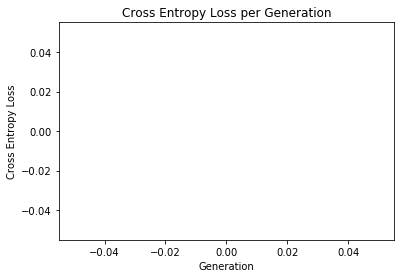

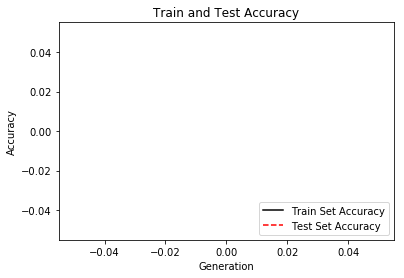

In [12]:
# Display model performance
%matplotlib inline
plt.plot(loss_vec, 'k--')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()


plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()